The goal of this study is to identify whether the ULEZ policy implemented in London has been effective at reducing air pollution caused by vehicles. To achieve this answer, causal inferential analysis will be used to provide a reliable quantitaive answer.

We have mined data on air quality in London of two different Boroughs Kensington (and Chelsea) (KC1) and Enfield (EN7). The dataset contains data for air quality before and after ULEZ in KC1 as well as the air quality data for EN7 before and after ULEZ in KC1. Having this data will allow us to perform causal analysis through difference in differences techniques with EN7 acting as a control for KC1s treatment (introduction of ULEZ)

Data was sourced from Londonair.org.uk

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# importing dataframe (df)
df = pd.read_csv("AirQualityData.csv", header=None)
#print(df.head())
#print(df.info())

In [3]:
# data cleaning

# assigning column names
column_names = ["location","pollutant","datetime","presence","unit","rebate"]
df.columns = column_names

# converting datetime column to a pandas datetime object
df.datetime = pd.to_datetime(df.datetime,dayfirst=True)

# dropping rebate column
df.drop("rebate",axis=1,inplace=True)

# dropping nan values
df=df.dropna()

#print(df.head())
#print(df.info())

In [4]:
# data wrangling

# adding a year and month column
df["year"] = df.datetime.dt.year
df["month"] = df.datetime.dt.month

# adding a season column
winter_months = [12,1,2]
spring_months = [3,4,5]
summer_months = [6,7,8]
autumn_months = [9,10,11]
conditions = [
    df['month'].isin(winter_months),
    df['month'].isin(spring_months),
    df['month'].isin(summer_months),
    df['month'].isin(autumn_months)]
choices = ['winter', 'spring', 'summer', 'autumn']
df['season'] = np.select(conditions, choices, default='unknown')

# adding a column with a binary variable for KC1 being under ULEZ or not (ULEZ introdcution in KC1 was 25 October 2021)
kc1_ulez = pd.to_datetime("25/1/2021",dayfirst=True)
df["kc1_ulez"] = np.where(df['datetime'] >= kc1_ulez, 1, 0)

# enfield went under ULEz 29/08/2023 so should we deside to use it as a control in causal analysis we need to remove any data from KC1 and EN7 from that date onwards
cutoff_date = pd.to_datetime("29/08/2023",dayfirst=True)
df = df[df.datetime < cutoff_date]

# to balance the data, any values above 946 days prior to 25/01/2021 will be removed
cutoff_date2 = pd.to_datetime("26/06/2018", dayfirst=True)
df = df[df.datetime > cutoff_date2]

print(df.head())
print(df.info())
print(df.location.unique())

      location pollutant            datetime  presence unit  year  month  \
21769      KC1       NO2 2018-06-26 01:00:00      15.5  ppb  2018      6   
21770      KC1       NO2 2018-06-26 02:00:00      38.1  ppb  2018      6   
21771      KC1       NO2 2018-06-26 03:00:00      37.3  ppb  2018      6   
21772      KC1       NO2 2018-06-26 04:00:00      28.3  ppb  2018      6   
21773      KC1       NO2 2018-06-26 05:00:00      24.9  ppb  2018      6   

       season  kc1_ulez  
21769  summer         0  
21770  summer         0  
21771  summer         0  
21772  summer         0  
21773  summer         0  
<class 'pandas.core.frame.DataFrame'>
Index: 88066 entries, 21769 to 146039
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   location   88066 non-null  object        
 1   pollutant  88066 non-null  object        
 2   datetime   88066 non-null  datetime64[ns]
 3   presence   88066 non-null  float64     

# Exploratory Analysis - Kensington and Chelsea Data

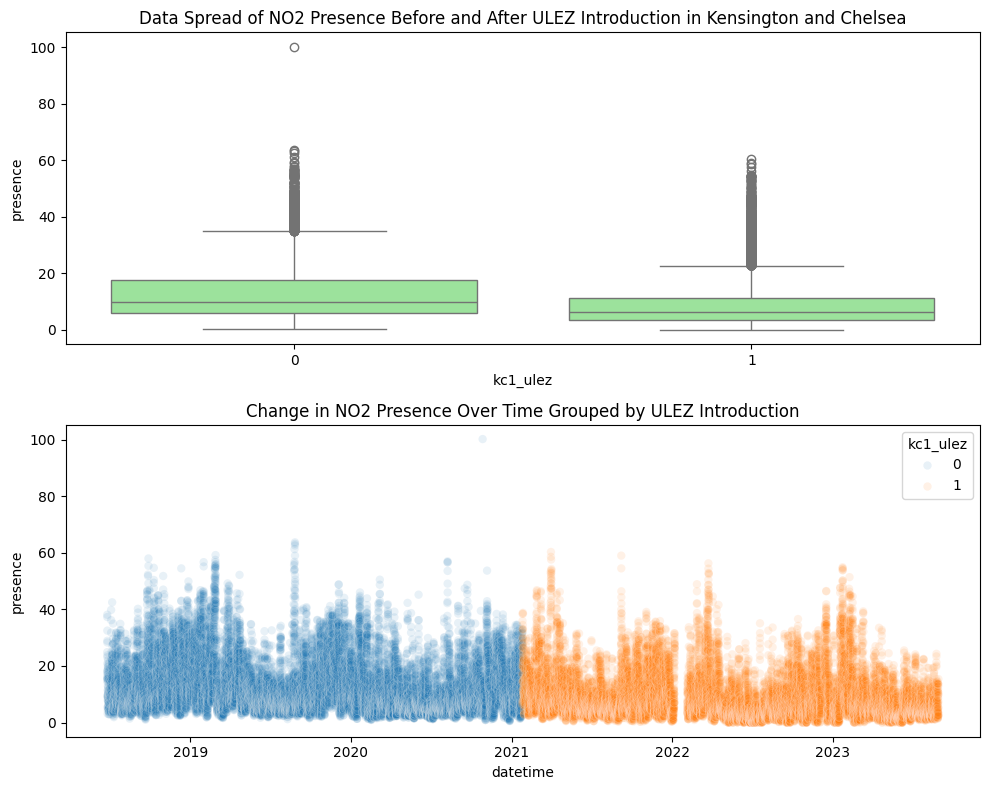

In [5]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.boxplot(data=df,x=df["kc1_ulez"][df.location == "KC1"],y=df["presence"][df.location == "KC1"],color = "lightgreen")
plt.title("Data Spread of NO2 Presence Before and After ULEZ Introduction in Kensington and Chelsea")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df["datetime"][df.location == "KC1"],y=df["presence"][df.location == "KC1"],hue="kc1_ulez",color = "lightgreen", alpha=0.1)
plt.title("Change in NO2 Presence Over Time Grouped by ULEZ Introduction")

plt.tight_layout()
plt.show()


At a glance at the boxplots we can see that the mean and standard deviation is lower in group 1 (ULEZ) as opposed to group 2 (no ULEZ). This indicates that the presence of ULEZ is associated with a decline in average NO2 presence in the air whether the difference is significant or not will require statistical testing (T-test or non-paramteric alternative). The scatter plot, however, struggles to easily visualize this trend indicating a need for statistical testing (spearmans rank to test if presence increases or declines with time). 

# Statistical Testing (and Assumption Testing) - Kensington and Chelsea Data

C:\Users\scada\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22469.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\scada\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21279.
  res = hypotest_fun_out(*samples, **kwds)


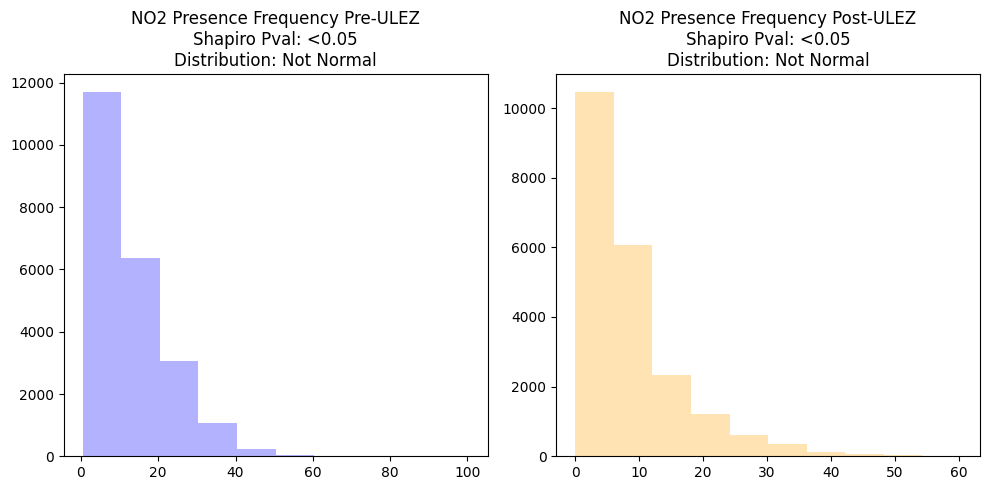

Despite the not normally distributed data, since we have a lot of data we can rely on the Central Limit Theorom which suggests our mean accurately represents the true mean enough to continue with a T-test.


T-Test Results:
P-value: 0.0 (<0.05)
Significance: Significantly Different
T-Stat: 52.864011090704736 - massive difference in groups


In [6]:
# boxplots
group_0 = df.presence[df.kc1_ulez == 0][df.location == "KC1"]
group_1 = df.presence[df.kc1_ulez == 1][df.location == "KC1"]

stat_0,pval_0 = stats.shapiro(group_0)
stat_1,pval_1 = stats.shapiro(group_1)

if pval_0 > 0.05:
    signif_0 = ">0.05"
    distrib_0 = "Normal"
else:
    signif_0 = "<0.05"
    distrib_0 = "Not Normal"

if pval_1 > 0.05:
    signif_1 = ">0.05"
    distrib_1 = "Normal"
else:
    signif_1 = "<0.05"
    distrib_1 = "Not Normal"
    

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(group_0,color = "blue", alpha=0.3, label="Pre-ULEZ")
title = f"NO2 Presence Frequency Pre-ULEZ\nShapiro Pval: {signif_0}\nDistribution: {distrib_0}"
plt.title(title)

plt.subplot(1,2,2)
plt.hist(group_1,color = "orange", alpha =0.3, label ="Post-ULEZ")
title = f"NO2 Presence Frequency Post-ULEZ\nShapiro Pval: {signif_1}\nDistribution: {distrib_1}"
plt.title(title)

plt.tight_layout()
plt.show()

print("Despite the not normally distributed data, since we have a lot of data we can rely on the Central Limit Theorom which suggests our mean accurately represents the true mean enough to continue with a T-test.")
print("\n")

print("T-Test Results:")
stat, pval = stats.ttest_ind(group_0,group_1)
if pval < 0.05:
    p = "<0.05"
    signif = "Significantly Different"
else:
    p = ">0.05"
    signif = "Not Significantly Different"
    
print(f"P-value: {pval} ({p})\nSignificance: {signif}\nT-Stat: {stat} - massive difference in groups")

In [7]:
# scatter plot - spearmans rank
#x = df.datetime[df.location=="KC1"]
x = list(range(0,len(df.datetime[df.location=="KC1"]),1))
y = df.presence[df.location=="KC1"]
correlation, pval = stats.spearmanr(x,y)
if pval < 0.05:
    p = "<0.05"
    signif = "Significantly Correlated"
else:
    p = ">0.05"
    signif = "Not Significantly Correlated"
    
print(f"The Pval is: {pval} ({p})\nIndicating the datsets are: {signif}\nThe correlation stat: {correlation} indicates a weak negative monotonic relationship.")

The Pval is: 0.0 (<0.05)
Indicating the datsets are: Significantly Correlated
The correlation stat: -0.34622803113794093 indicates a weak negative monotonic relationship.


Based off of our statistical testing so far we can conclude that there is an association between the presence of ULEZ and the concentration of NO2 in the air where NO2 presence was lower when ULEZ was present. However, we can only suggest association at this stage requiring causal inferential analysis for detail.

# Exploratory Analysis - Kensington and Chelsea Data

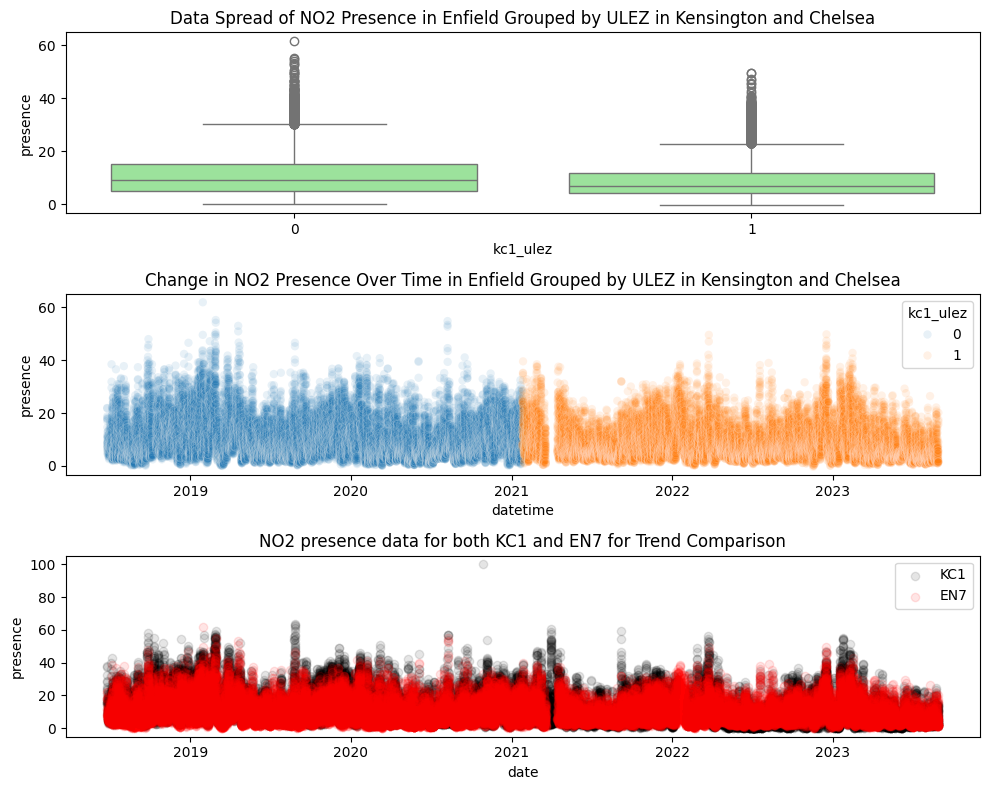

In [8]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
sns.boxplot(data=df,x=df["kc1_ulez"][df.location == "EN7"],y=df["presence"][df.location == "EN7"],color = "lightgreen")
plt.title("Data Spread of NO2 Presence in Enfield Grouped by ULEZ in Kensington and Chelsea")

plt.subplot(3,1,2)
sns.scatterplot(data=df,x=df["datetime"][df.location == "EN7"],y=df["presence"][df.location == "EN7"],hue="kc1_ulez",color = "lightgreen", alpha=0.1)
plt.title("Change in NO2 Presence Over Time in Enfield Grouped by ULEZ in Kensington and Chelsea")

plt.subplot(3,1,3)
plt.scatter(x=df["datetime"][df.location == "KC1"],y=df["presence"][df.location == "KC1"], color="black", alpha=0.1,label="KC1")
plt.scatter(x=df["datetime"][df.location == "EN7"],y=df["presence"][df.location == "EN7"], color="red", alpha=0.1, label="EN7")
plt.title("NO2 presence data for both KC1 and EN7 for Trend Comparison")
plt.xlabel("date")
plt.ylabel("presence")
plt.legend()
            
plt.tight_layout()
plt.show()


In the boxplots, Enfield at a glance appear to be quite similar to Kensington and Chelsea (KC1) before and after the ULEZ KC1 thusly will also need statistical testing. The scatterplot, again, shows little association requiring further statistical testing to observe any correlation. Finally the second scatter plot shows that Enfield and KC1 appear to have similar trends. This is good because it could mean that confounders between the two datasets are the same or similar with the only difference being the treatment (ULEZ presence) allowing for a potential difference in differences analysis.

# Statistical Testing (and Assumption Testing) - Enfield

C:\Users\scada\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22392.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\scada\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21926.
  res = hypotest_fun_out(*samples, **kwds)


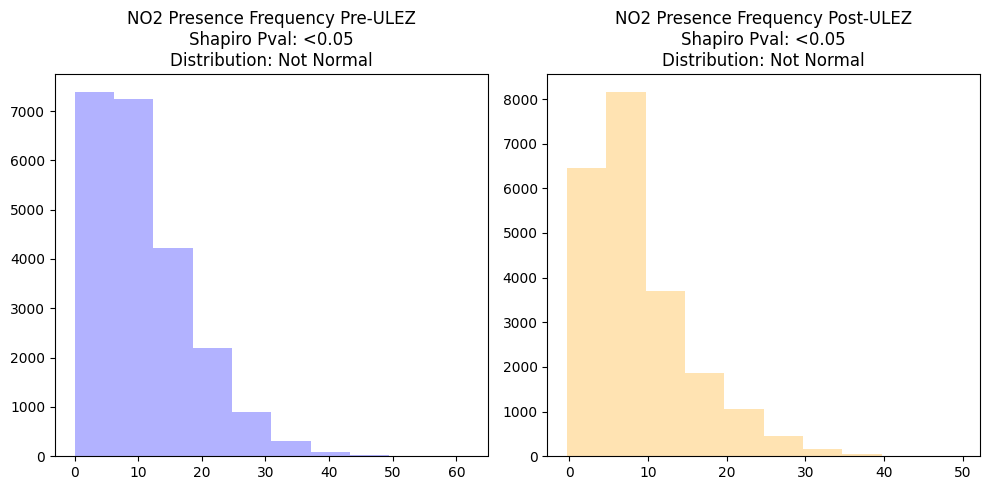

Despite the not normally distributed data, since we have a lot of data we can rely on the Central Limit Theorom which suggests our mean accurately represents the true mean enough to continue with a T-test.


T-Test Results:
P-value: 7.51883286725207e-203 (<0.05)
Significance: Significantly Different
T-Stat: 30.548873542973357 - massive difference in groups


In [9]:
# boxplots
group_0 = df.presence[df.kc1_ulez == 0][df.location == "EN7"]
group_1 = df.presence[df.kc1_ulez == 1][df.location == "EN7"]

stat_0,pval_0 = stats.shapiro(group_0)
stat_1,pval_1 = stats.shapiro(group_1)

if pval_0 > 0.05:
    signif_0 = ">0.05"
    distrib_0 = "Normal"
else:
    signif_0 = "<0.05"
    distrib_0 = "Not Normal"

if pval_1 > 0.05:
    signif_1 = ">0.05"
    distrib_1 = "Normal"
else:
    signif_1 = "<0.05"
    distrib_1 = "Not Normal"
    

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(group_0,color = "blue", alpha=0.3, label="Pre-ULEZ")
title = f"NO2 Presence Frequency Pre-ULEZ\nShapiro Pval: {signif_0}\nDistribution: {distrib_0}"
plt.title(title)

plt.subplot(1,2,2)
plt.hist(group_1,color = "orange", alpha =0.3, label ="Post-ULEZ")
title = f"NO2 Presence Frequency Post-ULEZ\nShapiro Pval: {signif_1}\nDistribution: {distrib_1}"
plt.title(title)

plt.tight_layout()
plt.show()

print("Despite the not normally distributed data, since we have a lot of data we can rely on the Central Limit Theorom which suggests our mean accurately represents the true mean enough to continue with a T-test.")
print("\n")

print("T-Test Results:")
stat, pval = stats.ttest_ind(group_0,group_1)
if pval < 0.05:
    p = "<0.05"
    signif = "Significantly Different"
else:
    p = ">0.05"
    signif = "Not Significantly Different"
    
print(f"P-value: {pval} ({p})\nSignificance: {signif}\nT-Stat: {stat} - massive difference in groups")

In [10]:
# scatter plot - spearmans rank
#x = df.datetime[df.location=="KC1"]
x = list(range(0,len(df.datetime[df.location=="EN7"]),1))
y = df.presence[df.location=="EN7"]
correlation, pval = stats.spearmanr(x,y)
if pval < 0.05:
    p = "<0.05"
    signif = "Significantly Correlated"
else:
    p = ">0.05"
    signif = "Not Significantly Correlated"
    
print(f"The Pval is: {pval} ({p})\nIndicating the datsets are: {signif}\nThe correlation stat: {correlation} indicates a weak negative monotonic relationship.")

The Pval is: 0.0 (<0.05)
Indicating the datsets are: Significantly Correlated
The correlation stat: -0.18247044209987387 indicates a weak negative monotonic relationship.


## Comparing the statistical analysis between Enfield and Kensington (and Chelsea)

The independent T-tests showed a significant reduction in NO2 presence between pre and post ULEZ presence in Kensington and Chelsea in both Kensington (and Chelsea) and Enfield indicating a general downward trend in NO2 presence, likely due to spatial or temproal trends.

However, the larger T-statistic and stronger negative correlation with time seen in Kensington and Chealsea provide preliminary associative evidence that the downward trend may be greater than that in Enfield.
This trend is consistent with the hypothesis that ULEZ has led to an impact on the presence of NO2. 

A difference in differences (DiD) causal inferential analysis approach can be used to compare the change betweem the 2 boroughs with Enfield acting as a control group for Kensington and Chealsea providing a quantitative result.

# Causal Inferential Analysis

In [11]:
import statsmodels.api as sm
# the formula to for the DiD regression is presence ~ post + treated + post:treated
# Creating the treated dummy variable: 1 for KC1 (treatment), 0 for EN7 (control)
df['treated'] = (df['location'] == 'KC1').astype(int)

did_model = sm.OLS.from_formula('presence ~  kc1_ulez + treated + kc1_ulez:treated', data=df).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:               presence   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1480.
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:33:50   Log-Likelihood:            -3.0613e+05
No. Observations:               88066   AIC:                         6.123e+05
Df Residuals:                   88062   BIC:                         6.123e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.9025      0.052  

Assuming that the control group is a True counter factor of the treatement group we can conclude that the introduction of ULEZ has reduced Kensington and Chelseas NO2 presence by -2.2681 ppb which is significantly different from before the implentation of ULEZ.